# Self-Attention from Scratch: Finding the Largest Number in a Sequence

This notebook demonstrates a from-scratch implementation of the **self-attention mechanism** (the core of Transformer architectures) to solve a simple but illustrative task: identifying the **largest number** in a numerical sequence.

---

### Self-Attention Overview

Self-attention allows a model to dynamically weigh the importance of each element in a sequence **in the context of the entire sequence**. For each token (in this case, each number), the model computes:

- A **query**: representing the question "What am I looking for?"
- A **key**: representing "What do I offer?"
- A **value**: the information carried by the token.

Attention weights are calculated by taking scaled dot-products between queries and keys. These weights are then used to combine the values — giving more influence to elements considered more relevant.

---

### Why This Works for Finding the Maximum

Although the model has no hard-coded notion of "greater than", it learns to **internally represent and compare magnitudes** through the training process.

Here's the intuition:

- During training, the model repeatedly sees sequences where the label is **the index of the maximum number**.
- To minimize loss, the model must produce an output where that position gets the highest final score.
- Through backpropagation, it adjusts its internal weights so that:
  - **Larger input values produce stronger key and value representations**.
  - **Queries learn to “seek” high-magnitude patterns** across the sequence.
- The attention mechanism then amplifies contributions from large values — effectively letting the model **"focus on the biggest number"** regardless of its position in the sequence.
- The final feed-forward layers pick up on this focused representation and translate it into a position prediction.

In essence, the model transforms numeric comparison into a **learned attention pattern** — using dot-product similarity to approximate magnitude-based relevance.

---

### Key Steps in the Pipeline

- Generate sequences of fixed length (`seq_len`) with random numbers _(in this example, `seq_len` is kept in the range [6,15] and every number in each sequence is in the range [0,1000])_.
- Normalize each sequence to ensure scale consistency.
- Embed scalar inputs into dense vectors.
- Compute self-attention using queries, keys, and values.
- Aggregate contextual information using attention weights.
- Use a feed-forward network to map the attended representation to a position index.
- Train and evaluate the model on randomly generated sequences.
- Visualize performance (e.g., using a confusion matrix).

---

### Final Notes

This project offers an intuitive, hands-on look at how **attention-based architectures** work — even outside of language modeling. While the task here is simple, the underlying mechanism is the same as in modern Transformers: **learn what to pay attention to** in order to solve a task.

Despite the simplicity of the model, we achieve **high accuracy without any explicit comparison logic** — a clear demonstration of how self-attention learns to capture patterns based on context and structure.

> _Note: This model is not optimized for performance. The focus here is educational — to demystify the mechanics of self-attention and show how it can generalize beyond text-based applications._


In [41]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [42]:
seq_len = np.random.randint(6,15)
print(f"seq_len: {seq_len}")

seq_len: 10


In [43]:
train_samples = 10000
train_data_input = torch.Tensor([[np.random.randint(1000) for _ in range(seq_len)] for _ in range(train_samples)])

In [44]:
train_data_input

tensor([[965., 876.,  28.,  ..., 515., 574., 905.],
        [ 45., 202., 846.,  ..., 939., 753.,  61.],
        [879., 965., 819.,  ..., 342., 220., 170.],
        ...,
        [526., 482., 110.,  ..., 116., 979., 842.],
        [260., 267., 644.,  ..., 344., 308., 634.],
        [511., 408., 605.,  ...,  41., 236., 771.]])

In [45]:
class SelfAttentionMaximizer(nn.Module):
  def __init__(self, embedding_dim, seq_len):
    super().__init__()
    self.input_embed = nn.Linear(1, embedding_dim)
    self.w_q = nn.Linear(embedding_dim, embedding_dim)
    self.w_k = nn.Linear(embedding_dim, embedding_dim)
    self.w_v = nn.Linear(embedding_dim, embedding_dim)
    self.ffn1 = nn.Linear(embedding_dim*seq_len, 32)
    self.ffn2 = nn.ReLU()
    self.output_layer = nn.Linear(32, seq_len)


  def forward(self, x, embedding_dim):
    # normalize inputs
    x = (x - x.min(dim=1, keepdim=True)[0]) / (x.max(dim=1, keepdim=True)[0] - x.min(dim=1, keepdim=True)[0] + 1e-6)

    # convert each number ("token") to a dense embedding vector
    embedded_input = self.input_embed(x.unsqueeze(-1).float())

    # get query, key, value vectors for each token
    q = self.w_q(embedded_input) # shape (batch_size, seq_len, embedding_dim)
    k = self.w_k(embedded_input)
    v = self.w_v(embedded_input)

    # scale and normalize to weight
    raw_attention_weight = torch.matmul(q, k.transpose(-2,-1))
    attention = torch.softmax(raw_attention_weight/embedding_dim**0.5, dim=-1)

    output = torch.matmul(attention, v) # shape (batch_size, seq_len, embedding_dim)

    # Pass through FFN and get prediction
    x = output.view(output.shape[0], -1) # flatten (_,seq_len,embedding_dim)
    x = self.ffn1(x)
    x = self.ffn2(x)

    predicted_position_logits = self.output_layer(x)

    return predicted_position_logits

  def compute_loss(self, y_pred, y_true):
    criterion = nn.CrossEntropyLoss()
    loss = criterion(y_pred, y_true)
    return loss




In [46]:
# TRAINING AND TESTING LOOP

batch_size = 32
num_epochs = 20
embedding_dim = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# train-test split
dataset_size = train_data_input.shape[0]
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
indices = torch.randperm(dataset_size)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_data = train_data_input[train_indices].to(device)
test_data = train_data_input[test_indices].to(device)

model = SelfAttentionMaximizer(embedding_dim, seq_len).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    train_predicted_outcome = []

    for batch in range(0, train_data.shape[0], batch_size):
        x_batch = train_data[batch:batch + batch_size]
        y_batch = x_batch.argmax(dim=1).to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch, embedding_dim)
        loss = model.compute_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)
        predicted_positions = y_pred.argmax(dim=1)
        train_correct += (predicted_positions == y_batch).sum().item()
        train_total += y_batch.size(0)

        # Collect predictions
        train_predicted_outcome.append(predicted_positions.detach().cpu().numpy())

    avg_train_loss = train_loss / train_total
    train_accuracy = train_correct / train_total * 100
    train_predicted_outcome = np.concatenate(train_predicted_outcome)

    # ---- Testing ----
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    test_predicted_outcome = []
    test_true_outcome = []

    with torch.no_grad():
        for batch in range(0, test_data.shape[0], batch_size):
            x_batch = test_data[batch:batch + batch_size]
            y_batch = x_batch.argmax(dim=1).to(device)

            y_pred = model(x_batch, embedding_dim)
            loss = model.compute_loss(y_pred, y_batch)

            test_loss += loss.item() * x_batch.size(0)
            predicted_positions = y_pred.argmax(dim=1)
            test_correct += (predicted_positions == y_batch).sum().item()
            test_total += y_batch.size(0)

            # Collect predictions
            test_predicted_outcome.append(predicted_positions.detach().cpu().numpy())
            test_true_outcome.append(y_batch.detach().cpu().numpy())


    avg_test_loss = test_loss / test_total
    test_accuracy = test_correct / test_total * 100
    test_predicted_outcome = np.concatenate(test_predicted_outcome)
    test_true_outcome = np.concatenate(test_true_outcome)

    print(
        f"Epoch {epoch+1} | "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
        f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%"
    )

Using device: cuda
Epoch 1 | Train Loss: 2.3046, Train Acc: 9.72% | Test Loss: 2.3032, Test Acc: 9.90%
Epoch 2 | Train Loss: 2.3026, Train Acc: 10.40% | Test Loss: 2.3001, Test Acc: 10.40%
Epoch 3 | Train Loss: 1.9228, Train Acc: 35.23% | Test Loss: 0.7432, Test Acc: 79.00%
Epoch 4 | Train Loss: 0.2509, Train Acc: 94.16% | Test Loss: 0.1160, Test Acc: 97.10%
Epoch 5 | Train Loss: 0.0847, Train Acc: 98.06% | Test Loss: 0.0685, Test Acc: 98.50%
Epoch 6 | Train Loss: 0.0564, Train Acc: 98.70% | Test Loss: 0.0495, Test Acc: 98.75%
Epoch 7 | Train Loss: 0.0431, Train Acc: 98.91% | Test Loss: 0.0390, Test Acc: 98.95%
Epoch 8 | Train Loss: 0.0352, Train Acc: 99.00% | Test Loss: 0.0322, Test Acc: 99.20%
Epoch 9 | Train Loss: 0.0298, Train Acc: 99.08% | Test Loss: 0.0274, Test Acc: 99.30%
Epoch 10 | Train Loss: 0.0259, Train Acc: 99.17% | Test Loss: 0.0239, Test Acc: 99.40%
Epoch 11 | Train Loss: 0.0229, Train Acc: 99.28% | Test Loss: 0.0213, Test Acc: 99.50%
Epoch 12 | Train Loss: 0.0206, Trai

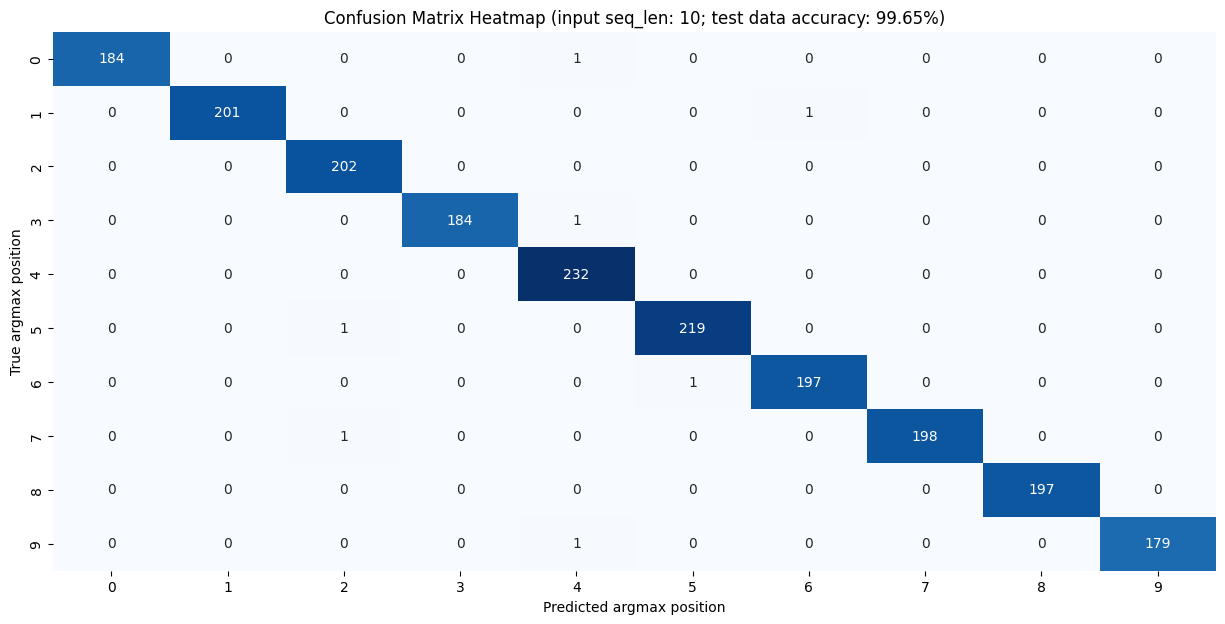

In [47]:
cm = confusion_matrix(test_true_outcome, test_predicted_outcome)

# Plot heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted argmax position")
plt.ylabel("True argmax position")
plt.title(f"Confusion Matrix Heatmap (input seq_len: {seq_len}; test data accuracy: {round(test_accuracy,2)}%)")
plt.show()

## Inference

Using the trained model to predict the largest number in random test sequences

In [48]:
def run_inference(model, raw_sequence, embedding_dim, seq_len):
    model.to("cpu")
    model.eval()
    with torch.no_grad():
        # Prepare input
        x = torch.tensor(raw_sequence).unsqueeze(0)  # [1, len]
        # Pad/truncate
        if x.shape[1] < seq_len:
            pad = seq_len - x.shape[1]
            x = torch.cat([x, torch.zeros(1, pad)], dim=1)
        elif x.shape[1] > seq_len:
          print("Please input a smaller sequence")

        # Run model
        logits = model(x, embedding_dim)
        prediction = torch.argmax(logits, dim=1).item()
    return prediction


In [52]:
for _ in range(10):
  test_seq = [np.random.randint(100) for _ in range(seq_len)]
  prediction = run_inference(model, test_seq, embedding_dim, seq_len)
  print(f"Largest number in {test_seq} ---> ", test_seq[prediction])

Largest number in [60, 8, 90, 98, 59, 79, 8, 17, 54, 54] --->  98
Largest number in [49, 46, 34, 28, 68, 73, 29, 4, 59, 31] --->  73
Largest number in [75, 16, 5, 1, 16, 26, 30, 64, 10, 60] --->  75
Largest number in [68, 1, 52, 84, 33, 19, 69, 77, 28, 17] --->  84
Largest number in [9, 82, 64, 6, 9, 70, 79, 77, 45, 54] --->  82
Largest number in [82, 17, 82, 91, 95, 2, 75, 26, 32, 45] --->  95
Largest number in [8, 69, 94, 97, 13, 6, 6, 26, 4, 49] --->  97
Largest number in [93, 18, 25, 49, 57, 88, 81, 43, 15, 65] --->  93
Largest number in [43, 36, 1, 41, 81, 99, 65, 87, 92, 15] --->  99
Largest number in [60, 7, 11, 83, 90, 35, 93, 61, 55, 47] --->  93


## Conclusion

In this notebook, we implemented the **self-attention mechanism from scratch** to solve a simple yet insightful task: identifying the **position of the largest number in a sequence**.

The model achieved a **test accuracy of 99.65%**, correctly predicting the position of the maximum value in nearly all test sequences. This strong performance highlights how even a minimal self-attention network can effectively learn to focus on the most relevant parts of an input — without requiring deep architectures or extensive tuning.

We also tested the trained model on multiple **random sequences**, and it consistently predicted the correct position of the maximum value, further demonstrating its generalization ability.

This experiment offers an intuitive, hands-on understanding of **how self-attention works**, and why it's such a powerful concept. The ability to dynamically assign importance to different input elements is a foundational feature of the **Transformer architecture** — the core behind today’s most advanced models in NLP and beyond.
